https://mybinder.org/

In [1]:
import numpy as np
import pandas as pd
import re
from bs4 import BeautifulSoup
from datetime import datetime
from requests import get
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import math
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import warnings
warnings.filterwarnings('ignore')

# Hockey Goals and the Positions of Scoring

Many sports analysis have tried to find a different correlation betweening being a successful winning team, average team, and a losing team. As of right now, the only strong correlation between these is how many goals are scored. This begs the question, if goals scored is the strongest indicator of team status, then is there locations on the ice that determine a teams strongest scoring position?

To answer this, the location of goal data will need to be collected from every team in the NHL, along with the location from where the goal was scored. Then a cluster model will be created to determine:
- Goal scoring zones
- Goal scoring zones percentage
- Goal vs shots percentages
- Goals scored vs goals blocked by opposing team

In order for us to get appropriate hockey data, we will be usinf ESPN.com in order to get positional data from where goals are scored.


![rink](tom.png)


In order to get shot positions, we need to be able to get every game That has been played this season for all teams. For that, obtaining the season schedule for games played.

![Schedule](schedule.png)

From here we can get a couple things:
- Date of Game
- Home/Away
- Team Played
- Win/Loss
- Score
- By regulation, Overtime, or shootout
- Goalie Played
- best player
<br>
<p>
    each game also has a game ID that can be found if the href tag for each game played. If you are to click on the score, you would be redirected to the link as shown in the html

![schedule](Schedule11.png)
![schedule2](Schedule21.png)

From this information we can now start web scrapping. First thing that needs to be done is getting the appropriate links for each NHL team possible. From webscrapping the teams page on espn.com, we get the following:

<img src="teams1.png" width=400 height=400 />


In [2]:
url = 'https://www.espn.com/nhl/teams'

web = get(url)
soup = BeautifulSoup(web.text,"html.parser")

slaw = []
stew = soup.find('div',class_='layout is-9-3').find('div',class_='layout is-split').find_all('section')
for i,j in enumerate(stew):
    slaw.append(j.find('a').get('href')[16:])
slaw

['/bos/boston-bruins',
 '/buf/buffalo-sabres',
 '/det/detroit-red-wings',
 '/fla/florida-panthers',
 '/mtl/montreal-canadiens',
 '/ott/ottawa-senators',
 '/tb/tampa-bay-lightning',
 '/tor/toronto-maple-leafs',
 '/ari/arizona-coyotes',
 '/chi/chicago-blackhawks',
 '/col/colorado-avalanche',
 '/dal/dallas-stars',
 '/min/minnesota-wild',
 '/nsh/nashville-predators',
 '/stl/st-louis-blues',
 '/wpg/winnipeg-jets',
 '/car/carolina-hurricanes',
 '/cbj/columbus-blue-jackets',
 '/nj/new-jersey-devils',
 '/nyi/new-york-islanders',
 '/nyr/new-york-rangers',
 '/phi/philadelphia-flyers',
 '/pit/pittsburgh-penguins',
 '/wsh/washington-capitals',
 '/ana/anaheim-ducks',
 '/cgy/calgary-flames',
 '/edm/edmonton-oilers',
 '/la/los-angeles-kings',
 '/sj/san-jose-sharks',
 '/sea/seattle-kraken',
 '/van/vancouver-canucks',
 '/vgk/vegas-golden-knights']

Now, a problem begins to show from this point. It should be noted that each NHL team plays 82 games a season, and with 32 teams in the NHL, there are a total of 1312 games played. This brings the problem, as each game has around 200 data points. We can see that as we get the games that have been played, this puts a lot of strain on the computer. 

In [3]:
def exercise(html):
    keys = datetime.strptime(html[0].get_text()[5:]+" 2021", '%b %d %Y')
    tip =html[1].get_text().split()
    if tip[0]=='vs':
        tip[0]='Home'
    else:
        tip[0]='Away'
    opp = html[1].find('a').get('href').split('/')[-1].replace('-',' ').title()
    link = html[2].find_all('span')[1].find('a').get('href')
    loss = html[2].find_all('span')[0].get_text()
    score = html[2].find_all('span')[1].get_text()
    if len(score)==5:
        how = 'reg'
    else:
        how = score[4:]
        score = score[:4]
    dep = html[4].get_text()
    piping = html[5].get_text()
    return([keys,tip[0],opp,link,loss,score,how,dep,piping])

def schedules(html):
    keys = datetime.strptime(html[0].get_text()[5:]+" 2021", '%b %d %Y')
    link = html[2].find_all('span')[1].find('a').get('href')
    ID = link.split('/')[-1]
    return([ID,keys,link])

In [4]:
#######################Do Not Run###############################################
def linking_games(url,team):
    url =url+team
    data = get(url)
    soup=BeautifulSoup(data.text,"html.parser")
    table = soup.find('tbody')
    games = table.find_all('tr')
    indexing = dict()
    
    for i in range(1,len(games)):
        key = games[i].find_all('td')
        post = len(key)
        if post == 6:
            keys = i
            indexing[keys]=schedules(key)
        elif post ==5:
            break
        else:
            pass
    return(pd.DataFrame.from_dict(indexing,columns = ['GameID','Date','Link'], orient ='index'))

In [5]:
#######################Do Not Run###############################################
url = 'https://www.espn.com/nhl/team/schedule/_/name'
ting = []
for i in slaw:
    ting.append(linking_games(url,i))
alt = pd.concat(ting, ignore_index=True)
alt.head()

,GameID,Date,Link
0,401349153,2021-10-16,https://www.espn.com/nhl/game/_/gameId/401349153
1,401349183,2021-10-20,https://www.espn.com/nhl/game/_/gameId/401349183
2,401349195,2021-10-22,https://www.espn.com/nhl/game/_/gameId/401349195
3,401349212,2021-10-24,https://www.espn.com/nhl/game/_/gameId/401349212
4,401349230,2021-10-27,https://www.espn.com/nhl/game/_/gameId/401349230


In [6]:
#######################Do Not Run###############################################
len(alt)

1868

When we remove duplicates we get the following games played so far this season:

In [7]:
#######################Do Not Run###############################################
alt1 = alt.drop_duplicates()
len(alt1)

934

Because of the strain put on the computer, the focus on this reasearch will be narrowed down to one team. The team choosen is my favorite team, The Las Vegas Golden Knights. 

In [8]:
def exercise(html):
    keys = datetime.strptime(html[0].get_text()[5:]+" 2021", '%b %d %Y')
    tip =html[1].get_text().split()
    if tip[0]=='vs':
        tip[0]='Home'
    else:
        tip[0]='Away'
    opp = html[1].find('a').get('href').split('/')[-1].replace('-',' ').title()
    link = html[2].find_all('span')[1].find('a').get('href')
    loss = html[2].find_all('span')[0].get_text()
    score = html[2].find_all('span')[1].get_text()
    if len(score)==5:
        how = 'reg'
    else:
        how = score[4:]
        score = score[:4]
    dep = html[4].get_text()
    piping = html[5].get_text()
    return([keys,tip[0],opp,link,loss,score,how,dep,piping])

def schedules(html):
    keys = datetime.strptime(html[0].get_text()[5:]+" 2021", '%b %d %Y')
    link = html[2].find_all('span')[1].find('a').get('href')
    ID = link.split('/')[-1]
    return([ID,keys,link])

In [9]:
url = 'https://www.espn.com/nhl/team/schedule/_/name/vgk/vegas-golden-knights'
data = get(url)
soup=BeautifulSoup(data.text,"html.parser")
table = soup.find('tbody')
games = table.find_all('tr')
indexing = dict()

In [10]:
for i in range(1,len(games)):
    key = games[i].find_all('td')
    post = len(key)
    if post == 6:
        keys = i
        indexing[keys]=exercise(key)
    elif post ==5:
        break
    else:
        pass

team = pd.DataFrame.from_dict(indexing,columns=['Date','Home/Away','Opponent','link','w/l','score','how','goalie','mvp'], orient ='index')
team.head()

,Date,Home/Away,Opponent,link,w/l,score,how,goalie,mvp
1,2021-10-12,Home,Seattle Kraken,https://www.espn.com/nhl/game/_/gameId/401349135,W,4-3,reg,Lehner,Pacioretty
2,2021-10-14,Away,Los Angeles Kings,https://www.espn.com/nhl/game/_/gameId/401349149,L,6-2,reg,Lehner,Dadonov
3,2021-10-20,Home,St Louis Blues,https://www.espn.com/nhl/game/_/gameId/401349184,L,3-1,reg,Lehner,Lehner
4,2021-10-22,Home,Edmonton Oilers,https://www.espn.com/nhl/game/_/gameId/401349198,L,5-3,reg,Lehner,Roy
5,2021-10-24,Home,New York Islanders,https://www.espn.com/nhl/game/_/gameId/401349215,L,2-0,reg,Lehner,Lehner


Now, we can focus on getting the information from the shot chart. This posses its own problems as we will need to get the following information:
- Type of data point
    - hit
    - block
    - shot
    - score
- who scored the goal (and possible assist)
- position on ice

For all of that information, we can find in the html code itself. But first some basic understanding of a professional Ice Hockey rink. The standard NHL rink has a length of ~200 ft and a width of ~85 ft. This will be important for figuring out position on the ice. We do this by getting the css position imputs for each point and apply that to the length and width of a hockey rink.

Another item of intrest that we can get is the names of those doing the action. In each point data is a short description of what happend.
<p>
    one example is as follows:<br>
    <b>Goal by Max Pacioretty, with assist from Mark Stone</b>
</p>
<br>
Since the pattern of description has the person doing the action first, with the next person either helping or having the action done to them, there names can be extracted and applied.<br>
When the links are run we get the data for each game including the opposing teams data.

In [11]:
def gamecast(link): 
    data = get(link)
    soup=BeautifulSoup(data.text,"html.parser")
    board = (soup.find('div',class_='ShotChart__court__wrap')).find_all('li')
    return(board)

def px_to_ft(lst):
    #constants
    length = 200 #ft
    width = 85 #ft
    pix = 0.000868 #px to ft

    if len(lst)>4 or len(lst)<4:
        return('List is too short')
    
    x = length*(float(lst[2])/100)-float(lst[3])*pix 
    y = width*(float(lst[0])/100)-float(lst[1])*pix

    return(x,y)

def xypos(r):
    regex_position = r'[\d\.\d]+'
    return(re.findall(regex_position,r.get('style')))

def people(rex):
    regex_score = r'[A-Z][a-z]+,?\s+(?:[A-Z][a-z]*\.?\s*)?[A-Z][a-z]+'
    return(re.findall(regex_score,rex.find('span').get_text()))

In [12]:
ids = team['Date'].tolist()
link = team['link'].tolist()
alll = []

In [13]:
for i,e in enumerate(link):
    yo = pd.DataFrame(columns = ['Date','x','y','color','action','people'])   

    point = [px_to_ft(xypos(row)) for row in gamecast(e)]

    cssc = [(row.find('svg')).get('style').split()[1] for row in gamecast(e)]

    act = [(row.find('svg')).find('use').get('xlink:href')[19:] for row in gamecast(e)]

    peep = [people(row) for row in gamecast(e)]

    x, y = zip(*point)

    yo['Date'] = [ids[i] for j in x]
    yo['x'] = x
    yo['y'] = y
    yo['color'] = cssc
    yo['action'] = act
    yo['people'] = peep
    alll.append(yo)
score = pd.concat(alll, ignore_index=True)
score.head()

,Date,x,y,color,action,people
0,2021-10-12,189.993924,68.996924,#333f42,penalty,"[Alex Pietrangelo, Tripping Jaden Schwartz]"
1,2021-10-12,194.993924,46.990424,#333f42,hit,"[Brayden McNabb, Marcus Johansson]"
2,2021-10-12,33.993924,21.991924,#333f42,goal,"[Max Pacioretty, Mark Stone, Chandler Stephenson]"
3,2021-10-12,21.993924,46.990424,#333f42,block,"[Zach Whitecloud, Jeremy Lauzon]"
4,2021-10-12,10.993924,52.991424,#333f42,shot,"[Jonathan Marchessault, Philipp Grubauer]"


Now that the dataset has been obtained, two datasets will be made for further analysis. One being only the Golden Knights data, and the other being all data collected.

In [14]:
scoring = score[score['color']=='#333f42']

Now that the datasets have been created, We can look at the actions that happen in a hockey game

In [15]:
tic = scoring.groupby('action').count()
lack = tic.index.tolist()
tic

,Date,x,y,color,people
action,,,,,
block,853,853,853,853,853
goal,187,187,187,187,187
hit,1148,1148,1148,1148,1148
penalty,199,199,199,199,199
shot,2500,2500,2500,2500,2500


Next, to improve accuracy of clustering analysis, the rink will be folded in half, so that way, a general sense of location on the ice can be established.

In [16]:
def halfing(val,width):
    if val>width/2:
        return((width/2)-(val-(width/2)))
    else:
        return(val)

scoring['x1'] = scoring['x'].apply(lambda x: halfing(x,200))
scoring['y1'] = scoring['y']

score['x1'] = score['x'].apply(lambda x: halfing(x,200))
score['y1'] = score['y']

And Finally, distance from the shot to the goal as well as angle it was shot at will also be calculated.

In [17]:
def distance(lst):
    halx = 85/2
    haly = 11
    dx = (lst[0]-halx)**2
    dy = (lst[1]-haly)**2
    tank = np.sqrt(dx+dy)
    ang = math.degrees(math.atan2(dy,dx))
    return(tank)

def angle(lst):
    halx = 85/2
    haly = 11
    dx = (lst[0]-halx)**2
    dy = (lst[1]-haly)**2
    tank = np.sqrt(dx+dy)
    ang = math.degrees(math.atan2(dy,dx))
    return(ang)

scoring['distance'] = scoring[['x1','y1']].apply(distance, axis=1)
scoring['angle'] = scoring[['x1','y1']].apply(angle, axis=1)

score['distance'] = score[['x1','y1']].apply(distance, axis=1)
score['angle'] = score[['x1','y1']].apply(angle, axis=1)

In [18]:
for i in lack:
    scoring["action_"+i] = scoring['action'].apply(lambda x: True if x==i else False)
    score["action_"+i] = score['action'].apply(lambda x: True if x==i else False)
scoring.head()

,Date,x,y,color,action,people,x1,y1,distance,angle,action_block,action_goal,action_hit,action_penalty,action_shot
0,2021-10-12,189.993924,68.996924,#333f42,penalty,"[Alex Pietrangelo, Tripping Jaden Schwartz]",10.006076,68.996924,66.479307,72.572811,False,False,False,True,False
1,2021-10-12,194.993924,46.990424,#333f42,hit,"[Brayden McNabb, Marcus Johansson]",5.006076,46.990424,51.972156,42.657727,False,False,True,False,False
2,2021-10-12,33.993924,21.991924,#333f42,goal,"[Max Pacioretty, Mark Stone, Chandler Stephenson]",33.993924,21.991924,13.898767,59.085122,False,True,False,False,False
3,2021-10-12,21.993924,46.990424,#333f42,block,"[Zach Whitecloud, Jeremy Lauzon]",21.993924,46.990424,41.422334,72.014916,True,False,False,False,False
4,2021-10-12,10.993924,52.991424,#333f42,shot,"[Jonathan Marchessault, Philipp Grubauer]",10.993924,52.991424,52.496786,60.622799,False,False,False,False,True


Now that all of the data has been cleaned and prepared, a simple check on position will be performed. Since most hits in the NHL happen near the walls of the rink or "Boards", a simple test can be deteremined to see how accurate our positioning is.

In [19]:
X = scoring[scoring['action']=='hit']['x'].tolist()
Y = scoring[scoring['action']=='hit']['y'].tolist()

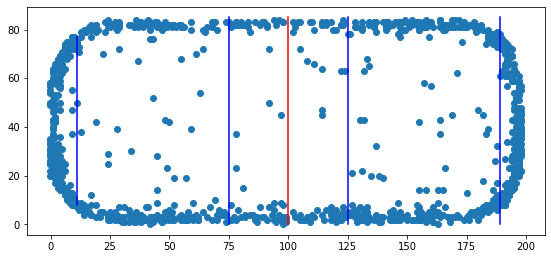

In [20]:
plt.figure(figsize=(9.28,4.19))
plt.scatter(X,Y)
plt.plot([100,100],[0,85],color = 'red')
plt.plot([75,75],[0,85],color = 'blue')
plt.plot([125,125],[0,85],color = 'blue')
plt.plot([11,11],[8,77],color = 'blue')
plt.plot([189,189],[0,85],color = 'blue')
plt.show()

From the graph above, it can be seen that a majority of hits are against the boards and there dose not seem to be any outliers that we should be worried about. It is safe to say that our position function works. However, a test needs to be run on the positions for half rink. For this, the same plot will be applied:

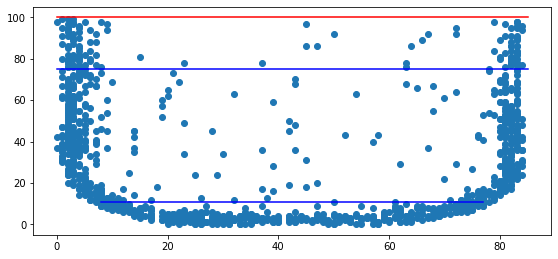

In [21]:
X1 = scoring[scoring['action_hit']==True]['x1'].tolist()
Y1 = scoring[scoring['action_hit']==True]['y1'].tolist()
plt.figure(figsize=(9.28,4.19))
plt.scatter(Y1,X1)
plt.plot([0,85],[100,100],color = 'red')
plt.plot([0,85],[75,75],color = 'blue')
plt.plot([8,77],[11,11],color = 'blue')

plt.show()

Again a defined boarder can be see and thus, it can be concluded that the ability to translate the function to be in half has worked.

## Analysis

From here, a look into the number such as position, distance, and angle will be analyzied.

<AxesSubplot:xlabel='distance', ylabel='Count'>

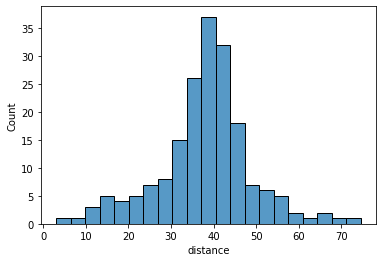

In [22]:
sns.histplot(x='distance',data=scoring[scoring['action_goal']==True])

From this histogram, most shots seem to be taken 30-50 feet away from the goal at any distance. 

<AxesSubplot:xlabel='angle', ylabel='Count'>

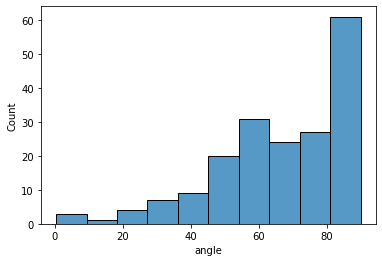

In [23]:
sns.histplot(x='angle',data=scoring[scoring['action_goal']==True])

It also seems that the most common angle on goal is between 60-80 degrees of the goal

https://builtin.com/data-science/data-clustering-python

<AxesSubplot:xlabel='x', ylabel='Count'>

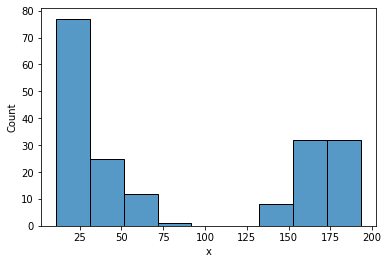

In [24]:
sns.histplot(x='x',data=scoring[scoring['action_goal']==True])

When the span of a complete rink is viewed, it is shown that most goals are made on the left side of the rink. In order to understand which side is left, look at the corrlating picture below:

<AxesSubplot:xlabel='x1', ylabel='Count'>

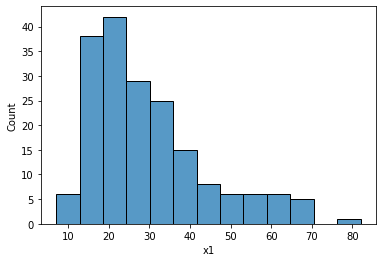

In [25]:
sns.histplot(x='x1',data=scoring[scoring['action_goal']==True])

It should also be noted that most goals happen when they are 10-40 feet from the back of the goal to the middle line.

<AxesSubplot:xlabel='y', ylabel='Count'>

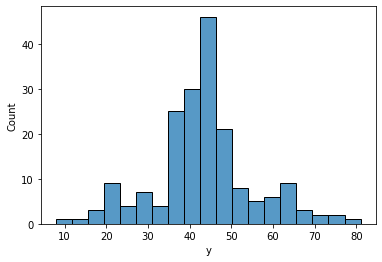

In [26]:
sns.histplot(x='y',data=scoring[scoring['action_goal']==True])

This plot shows that most goals are scored in the middle of the ice.

Finally, a correlation matrix will be created to vizually see if there is a correlation between certain actions and positions on the ice:

In [27]:
import sklearn
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

In [28]:
cor = scoring[['x1','y1','distance','angle','action_goal','action_shot','action_block']].corr()
cor.style.background_gradient(cmap='coolwarm')

,x1,y1,distance,angle,action_goal,action_shot,action_block
x1,1.000000,-0.009540,0.018286,0.041696,-0.064822,0.185916,-0.061478
y1,-0.009540,1.000000,0.873783,0.696058,0.018225,0.035452,0.002846
distance,0.018286,0.873783,1.000000,0.356774,-0.019327,-0.104209,-0.136863
angle,0.041696,0.696058,0.356774,1.000000,0.051130,0.090361,0.201554
action_goal,-0.064822,0.018225,-0.019327,0.051130,1.000000,-0.204134,-0.091723
action_shot,0.185916,0.035452,-0.104209,0.090361,-0.204134,1.000000,-0.470598
action_block,-0.061478,0.002846,-0.136863,0.201554,-0.091723,-0.470598,1.000000


The correlation matrix shows that Acions have no correlation to location, distance, and angles. Now, clustering will be applied to try and understand and define the zones of scoring goals. First we will find the optimal number of clusters needed to get the most accurate reading possible.

In [29]:
X = scoring[scoring['action_goal']==True][['y1','x1']].copy()
X_keep = X

In [30]:
wcss = []
for i in range(2, 11):
    kmeans = KMeans(n_clusters=i, random_state=0)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

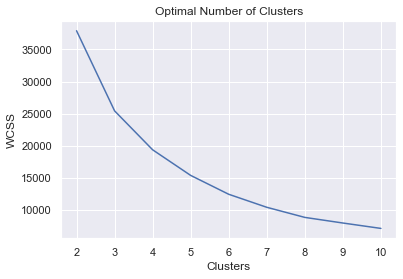

In [31]:
sns.set()
plt.plot(range(2, 11), wcss)
plt.title('Optimal Number of Clusters')
plt.xlabel('Clusters')
plt.ylabel('WCSS')
plt.show()

From this plot, it can be seen that 4 clusters is the most optimal and will be used in the actual model.When the model is applied to the goals scored, the following graphs are obtained.

Text(0.5, 1.0, 'Cluster Loaction to Goals')

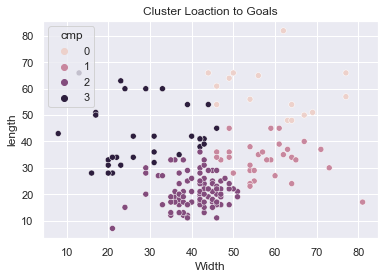

In [32]:
kmeans = KMeans(n_clusters=4,random_state=0,n_init=1, init='random', max_iter=5)
model = kmeans.fit(X)
ypred = model.predict(X)
X['cmp'] = ypred
sns.scatterplot(x='y1',y='x1',hue='cmp',data=X)
plt.xlabel('Width')
plt.ylabel('length')
plt.title('Cluster Loaction to Goals')

Text(0.5, 1.0, 'Cluster Location of Shots Blocked in Goal Areas')

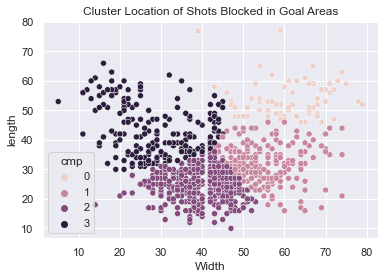

In [33]:
X_new = score[(score['action_block']==True)&(score['color']!='#333f42')][['y1','x1']]
yy = model.predict(X_new)
X_new['cmp'] = yy
sns.scatterplot(x='y1',y='x1',hue='cmp',data=X_new)
plt.xlabel('Width')
plt.ylabel('length')
plt.title('Cluster Location of Shots Blocked in Goal Areas')

Text(0.5, 1.0, 'Cluster Location of Shots in Goal Areas')

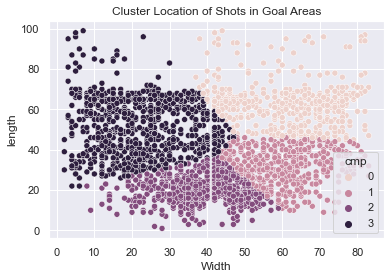

In [34]:
X_new1 = scoring[scoring['action_shot']==True][['y1','x1']]
yy1 = model.predict(X_new1)
X_new1['cmp'] = yy1
sns.scatterplot(x='y1',y='x1',hue='cmp',data=X_new1)
plt.xlabel('Width')
plt.ylabel('length')
plt.title('Cluster Location of Shots in Goal Areas')

Text(0, 0.5, 'length')

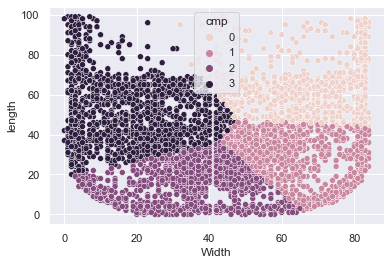

In [35]:
X_test = scoring[['y1','x1']]
X_test1 = score[['y1','x1']]
y_pred = model.predict(X_test)
y_pred1 = model.predict(X_test1)
scoring['cmp'] = y_pred
score['cmp'] = y_pred1
sns.scatterplot(x='y1',y='x1',hue='cmp',data=scoring)
plt.xlabel('Width')
plt.ylabel('length')

Finally, a statistical analysis can be made. First, a determination of what percentage of goals made are in each zone is done.

In [36]:
stats = scoring[scoring['action_goal']==True]
zero = len(stats[stats['cmp']==0])/len(stats)
one = len(stats[stats['cmp']==1])/len(stats)
two = len(stats[stats['cmp']==2])/len(stats)
three = len(stats[stats['cmp']==3])/len(stats)

In [37]:
print("Zone 0 {}% |Zone 1 {}% | Zone 2 {}% | Zone 3 {}% |".format(round(zero*100,2),round(one*100,2),round(two*100,2),round(three*100,2)))

Zone 0 8.02% |Zone 1 17.11% | Zone 2 58.29% | Zone 3 16.58% |


Next, a look at how many shots on goal become goals by zone

In [38]:
num = scoring[scoring['action_goal']==True]
dem = scoring[scoring['action_shot']==True]
zero1 = len(num[num['cmp']==0])/(len(dem[dem['cmp']==0])+len(num[num['cmp']==0]))
one1 = len(num[num['cmp']==1])/(len(dem[dem['cmp']==1])+len(num[num['cmp']==1]))
two1 = len(num[num['cmp']==2])/(len(dem[dem['cmp']==2])+len(num[num['cmp']==0]))
three1 = len(num[num['cmp']==3])/(len(dem[dem['cmp']==3])+len(num[num['cmp']==0]))

In [39]:
print("Zone 0 {}% |Zone 1 {}% | Zone 2 {}% | Zone 3 {}% |".format(round(zero1*100,2),round(one1*100,2),round(two1*100,2),round(three1*100,2)))

Zone 0 2.95% |Zone 1 6.57% | Zone 2 14.05% | Zone 3 3.85% |


And finally, from goals made verses shots blocked by the opposing team

In [40]:
num = scoring[scoring['action_goal']==True]
dem = score[(score['action_shot']==True)&(score['color']!='#333f42')]
zero2 = len(num[num['cmp']==0])/len(dem[dem['cmp']==0])
one2 = len(num[num['cmp']==1])/len(dem[dem['cmp']==1])
two2 = len(num[num['cmp']==2])/len(dem[dem['cmp']==2])
three2 = len(num[num['cmp']==3])/len(dem[dem['cmp']==3])

In [41]:
print("Zone 0 {}% |Zone 1 {}% | Zone 2 {}% | Zone 3 {}% |".format(round(zero2*100,2),round(one2*100,2),round(two2*100,2),round(three2*100,2)))

Zone 0 4.2% |Zone 1 7.06% | Zone 2 14.4% | Zone 3 4.78% |


Finally, a look at the silhouette analysis, and how well the clusters work out.

For n_clusters = 4 The silhouette_score is : 0.4265262571269137


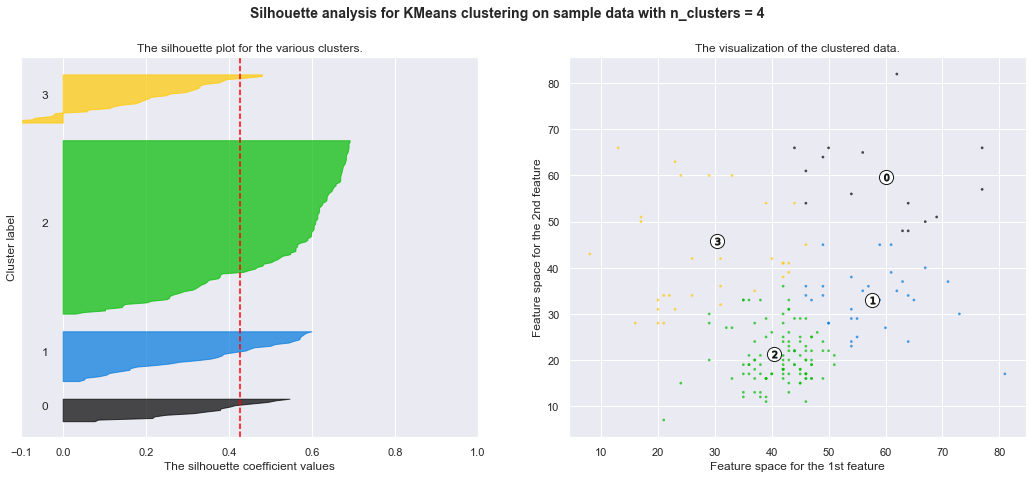

In [42]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18, 7)
n_clusters = 4

ax1.set_xlim([-0.1, 1])
# The (n_clusters+1)*10 is for inserting blank space between silhouette
# plots of individual clusters, to demarcate them clearly.
ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

# The silhouette_score gives the average value for all the samples.
# This gives a perspective into the density and separation of the formed
# clusters
silhouette_avg = silhouette_score(X_keep, ypred)
print("For n_clusters =", n_clusters,
      "The silhouette_score is :", silhouette_avg)

sample_silhouette_values = silhouette_samples(X_keep, ypred)

y_lower = 10
for i in range(n_clusters):
    # Aggregate the silhouette scores for samples belonging to
    # cluster i, and sort them
    ith_cluster_silhouette_values = \
        sample_silhouette_values[ypred == i]

    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.nipy_spectral(float(i) / n_clusters)
    ax1.fill_betweenx(np.arange(y_lower, y_upper),
                      0, ith_cluster_silhouette_values,
                      facecolor=color, edgecolor=color, alpha=0.7)

    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    y_lower = y_upper + 10  # 10 for the 0 samples

ax1.set_title("The silhouette plot for the various clusters.")
ax1.set_xlabel("The silhouette coefficient values")
ax1.set_ylabel("Cluster label")

# The vertical line for average silhouette coefficient of all the values
ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

ax1.set_yticks([])  # Clear the yaxis labels / ticks
ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

# 2nd Plot showing the actual clusters formed
colors = cm.nipy_spectral(ypred.astype(float) / n_clusters)
ax2.scatter(X['y1'], X['x1'], marker='.', s=30, lw=0, alpha=0.7,
            c=colors, edgecolor='k')

# Labeling the clusters
centers = model.cluster_centers_
# Draw white circles at cluster centers
ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
            c="white", alpha=1, s=200, edgecolor='k')

for i, c in enumerate(centers):
    ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                s=50, edgecolor='k')

ax2.set_title("The visualization of the clustered data.")
ax2.set_xlabel("Feature space for the 1st feature")
ax2.set_ylabel("Feature space for the 2nd feature")

plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
              "with n_clusters = %d" % n_clusters),
             fontsize=14, fontweight='bold')

plt.show()